# Scratch

In [17]:
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd")
import json

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk

import config

import utils
import metrics
import time
import plot
import svgd
import stein
import train
import kernels

from jax.experimental import optimizers

rkey = random.PRNGKey(0)

# make searcher

In [18]:
from itertools import product

In [32]:
d = {"one": [1, 1], "two": [2, 2]}

In [ ]:
def grid_search(hparams: dict):
    """traverse cartesian product of lists in hparams"""
    for h in product(hparams)

# Pickle model

In [2]:
sargs = config.get_svgd_args(config.config)
kernel = sargs["kernel"]

In [3]:
kernel

Transformed(init=<function without_state.<locals>.init_fn at 0x7fd49c6e17b8>, apply=<function without_state.<locals>.apply_fn at 0x7fd49c6e1840>)

In [4]:
x = np.array([1,2,3], dtype=np.float32)

params = kernel.init(rkey, x, x)

In [50]:
model = [kernel, params]

In [51]:
import pickle

In [56]:
a = np.array(3)

In [57]:
a

DeviceArray(3, dtype=int32)

In [58]:
str(a)

'3'

In [52]:
with open("file.pickle", "wb") as f:
    pickle.dump(model, f)
    
with open('file.pickle', 'rb') as handle:
    b = pickle.load(handle)

AttributeError: Can't pickle local object 'without_state.<locals>.init_fn'

# Read logs
and sort by config entry

In [5]:
ls ../runs

test1/


In [12]:
cfgs = []
data = []
metrics = []
tdir = "../runs/test1/"
for logdir in os.listdir(tdir):
    configfile, datafile, metricfile = [tdir + logdir + f for f in ["/config", "/data", "/metrics"]]
    with open(configfile, "r") as f:
        cfgs.append(json.load(f))
    with open(datafile, "r") as f:
        data.append(json.load(f))
    with open(metricfile, "r") as f:
        metrics.append(json.load(f))
        
out = zip(cfgs, data)

In [13]:
len(cfgs)

15

In [14]:
[c["kernel"]["layers"] for c in cfgs]

[[32, 32, 32],
 [32, 32, 32],
 [32, 32, 32, 2],
 [32, 32, 32, 2],
 [32, 32, 2],
 [32, 32, 2],
 [32, 32],
 [32, 2],
 [32, 2],
 [32, 32],
 [32, 32, 32],
 [32, 32, 2],
 [32, 2],
 [32, 32, 32, 2],
 [32, 32]]

Want: pd dataframe with structure:

y-axis: metric \
x-axis: layers (or learning rate, optimizer, ...)

In [16]:
metrics

[0.2103096,
 0.036900043,
 0.11703453,
 0.11971799,
 0.11273165,
 2.2435925,
 0.0012791828,
 2.1348662,
 0.17127702,
 0.20807171,
 2.2175035,
 0.113004446,
 0.11025192,
 2.237052,
 2.2076705]

In [10]:
cfgs[0]

{'svgd': {'target': 'Gaussian',
  'target_args': [0, 1],
  'n_particles': 100,
  'optimizer_svgd': 'Adagrad',
  'optimizer_svgd_args': [1]},
 'kernel': {'architecture': 'MLP', 'layers': [32, 32, 32]},
 'train_kernel': {'key': 0,
  'n_iter': 100,
  'ksd_steps': 1,
  'svgd_steps': 1,
  'optimizer_ksd': 'Adam',
  'optimizer_ksd_args': [0.01]},
 'metric': {'metric': 'Learned KSD', 'layers': [32, 32, 32, 2]}}

# Haiku

In [25]:
def net_fn(x):
    mlp = hk.Sequential([
        hk.Flatten(),
        hk.Linear(32), jax.nn.relu,
        hk.Linear(32), jax.nn.relu,
        hk.Linear(2)
    ])
    return mlp(x)

In [26]:
net = hk.transform(net_fn)

In [27]:
x = np.array([1.])

In [28]:
net.init(rkey, x)

frozendict({
  'linear': frozendict({
              'b': DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                                0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                                0., 0.], dtype=float32),
              'w': DeviceArray([[ 0.30432975, -0.20807576,  1.5253605 , -0.33471823,
                                 -0.819684  ,  0.07262449,  0.7509552 ,  0.39394718,
                                  1.1008915 , -0.08661515,  0.37275988,  0.6297104 ,
                                 -1.2111528 ,  0.37929875,  0.16987085, -0.01042716,
                                 -0.02237887, -0.25954643,  0.37912893,  0.3542186 ,
                                  1.0106695 ,  0.49792677,  0.9558354 ,  1.2206774 ,
                                 -1.1474493 ,  0.1913647 , -0.31445143,  0.7700437 ,
                                 -0.05240698,  0.64090383,  1.7368569 ,  0.27655005]],            dtype=float32),
            

In [20]:
m = hk.transform(vanilla_ard)
dist = metrics.Gaussian(0, 1)
x, y = dist.sample((2,))

params = m.init(rkey, x, y)

m.apply(params, x, y)

DeviceArray(0.3204255, dtype=float32)

## test thingy

In [3]:
import haiku as hk

In [3]:
target = metrics.Gaussian(0, 1) # target dist
n = 100 # nr particles

lr_svgd = 1
lr_ksd = 1e-2

n_steps = 1
ksd_steps = 1
svgd_steps = 300

In [4]:
from train import SVGD
kernel = kernels.mlp_ard
kernel = hk.transform(kernel)

opt_svgd = train.Optimizer(*optimizers.sgd(step_size=lr_svgd))
opt_ksd  = train.Optimizer(*optimizers.adam(step_size=lr_ksd))

svgd = SVGD(target, n, opt_svgd, kernel)

In [5]:
kernel_params, log = svgd.train_kernel(rkey, n_steps, ksd_steps, svgd_steps, opt_ksd)

100%|██████████| 1/1 [00:55<00:00, 55.72s/it]


In [6]:
log.keys()

dict_keys(['square_errors', 'KL Divergence', 'ksd', 'particles'])

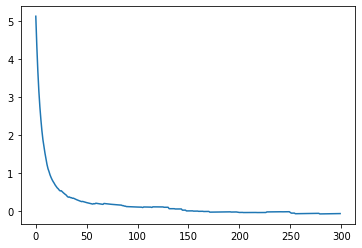

In [7]:
plt.plot(log["KL Divergence"])

In [9]:
key = random.PRNGKey(1)
key1, key2 = random.split(key)

In [10]:
samples = svgd.sample(key1, kernel_params, n_steps)

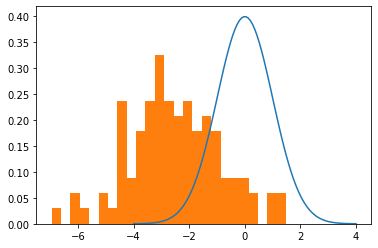

In [11]:
gr = np.linspace(-4, 4, 100)
_ = plt.plot(gr, vmap(target.pdf)(gr))
_ = plt.hist(samples[:, 0], bins=25, density=True)

In [12]:
dummies = target.sample((2,1))
init_params = kernel.init(key1, *dummies)
comparison_samples = svgd.sample(key, init_params, n_steps)

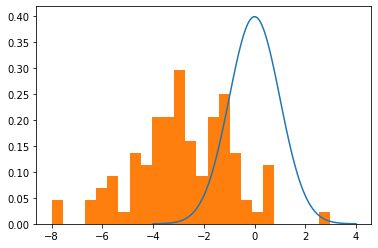

In [15]:
gr = np.linspace(-4, 4, 100)
_ = plt.plot(gr, vmap(target.pdf)(gr))
_ = plt.hist(comparison_samples[:, 0], bins=25, density=True)

# Haiku

In [4]:
from kernels import vanilla_ard

In [9]:
m = hk.transform(vanilla_ard)

dist = metrics.Gaussian(0, 1)

x, y = dist.sample((2,))

params = m.init(rkey, x, y)

m.apply(params, x, y)

In [10]:
slkfdj

NameError: name 'slkfdj' is not defined

## training

In [ ]:
ksd_squared = vmap(self.ksd_squared, (None, None, 0)) # operate on batch of particles
hypernetwork = self.hypernetwork
def current_step(i, j, steps):
    return i*steps + j
key1, key2 = random.split(key)

particles = init_svgd(key1, self.particle_shape)
opt_svgd_state = self.opt.init(particles)

particles = np.expand_dims(particles, 0) # batch dimension
params = hypernetwork.init(key2, particles)
opt_ksd_state = opt_ksd.init(params)

log = dict()
for i in range(n_iter):
    # update particles:
    params = opt_ksd.get_params(opt_ksd_state)
    particle_batch = []
    for j in range(svgd_steps):
        step = current_step(i, j, svgd_steps)

        particles = self.opt.get_params(opt_svgd_state)
        gp = -self.phistar(particles, params) # TODO gradient has wrong extra batch dim
        print(gp.shape)
        opt_svgd_state = self.opt.update(step, gp, opt_svgd_state)

        particle_batch.append(particles)
        utils.warn_if_nan(gp)

    # update network params:
    particle_batch = np.asarray(particle_batch, dtype=np.float32)
    log = metrics.append_to_log(log, {"particles": particle_batch})
    inner_updates = []
    ksds = []
    gradients = []
    for j in range(ksd_steps):
        step = current_step(i, j, ksd_steps)
        params = opt_ksd.get_params(opt_ksd_state)
        ksd, gk = value_and_grad(ksd_squared)(params, particle_batch)
        opt_ksd_state = opt_ksd.update(step, gk, opt_ksd_state)

#                inner_updates.append(params)
        ksds.append(ksd)
        gradients.append(gk)
        utils.warn_if_nan(ksd)
        utils.warn_if_nan(gk)
    update_log = {
        "ksd": ksds,
        "gradients": gradients,
    }
    log = metrics.append_to_log(log, update_log)


# Bug


In [ ]:
np.diff([1, 2, 4, 8])

In [ ]:
onp.diff([1, 2, 4, 8])

# class thingy

In [ ]:
class Test():
    def __init__(self, a=1):
        self.a = a
        
    def getf(self):
        def f():
            return self.a
        return f

In [ ]:
t = Test(5)
f = t.getf()
f()

In [ ]:
t.a = 3
f()

Right, of course this works: `a` is not a global variable, but `t.a` *is*, since the instance `t` is also available globally.

## jit `static_argnums` and classes

In [ ]:
class Test():
    def __init__(self, y):
        self.y = y
        self.var = 0
    
    def tfun(self, x):
        return self.y + x**2 + self.var
    tfun = utils.verbose_jit(tfun, static_argnums=0)
    
    def change(self):
        self.var += 1

In [ ]:
t = Test(5)

In [ ]:
from copy import deepcopy
tcopy = deepcopy(t)
print(t == tcopy)
# indeed:
print(id(t) == id(tcopy))

print("----------")
print(id(t))
print(id(tcopy))

print("---------")
print("But the id of the class instance never changes, even if its objects do:")
oldid = id(t)
t.change()
print(oldid == id(t))
print()
print("This means you gotta be careful, since jit recompiles only if the object id changes.")

In [ ]:
t.__eq__

In [ ]:
t.__hash__

# numpy indexing

In [ ]:
a = random.uniform(rkey, (20,))

In [ ]:
a

In [ ]:
idx = np.array([[1, 2, 3],
                [2, 3, 4]])

In [ ]:
a[idx]

# test `vmap` row column behaviour

In [ ]:
f = lambda x, y: 10*x + y

In [ ]:
fv  = vmap(f,  (None, 0))
fvv = vmap(fv, (0, None))

x = np.array([1,2])
f_matrix = fvv(x, x)

In [ ]:
f_matrix

# testing `stein.stein`

In [ ]:
d = 3
dist = metrics.Gaussian(np.zeros(d), 1)
xs = dist.sample((100,))

### Case 1: 
Input is $f: \mathbb R^d \to \mathbb R^d$.
Then 
$$\mathcal A_p [f] (x) \in \mathbb R^{d \times d}$$
and 
$$\mathcal A_p^T [f] (x) \in \mathbb R$$

In [ ]:
def f(x):
    x = np.array(x)
    assert x.shape == (d,)
    a = np.array([1,2,3])
    return x*2 + a
f([3.,2.,1])

In [ ]:
stein.stein(f, xs, dist.logpdf).shape

In [ ]:
stein.stein(f, xs, dist.logpdf, transposed=True)

### Case 2:
Input is $f: \mathbb R^d \to \mathbb R$.
Then 
$$\mathcal A_p [f] (x) \in \mathbb R^{d}.$$

Note that $\mathcal A_p^ T [f]$ makes no sense.

In [ ]:
def f(x):
    x = np.array(x)
    assert x.shape == (d,)
    a = np.array([1,2,3])
    return np.sum(x*2 + a)
f([3.,2.,1])

In [ ]:
stein.stein(f, xs, dist.logpdf).shape

In [ ]:
# stein.stein(f, xs, dist.logpdf, transposed=True) # throws an error

In [ ]:
def f(x):
    x = np.array(x)
    assert x.shape == (d,)
    a = np.array([1,2,3])
    return np.einsum("i,j->ij",2*x, a)
f([3.,2.,1])

In [ ]:
jacfwd(f)([3.,2.,1.])

In [ ]:
onp.einsum("iii->i", jacfwd(f)([3.,2.,1.]))

In [ ]:
np.einsum("ii", f([3,2,1]))

# jit stuff 

In [ ]:
def t(a, b):
    return a + b

In [ ]:
jacfwd(t)(1., 2.)

In [ ]:
@jit
def outer(defval, const=None):
    if const is None:
        const = defval
    
    def loss():
        return const
    return loss()
    

In [ ]:
outer(5, None)

In [ ]:
outer(5, 15)

In [ ]:
outer(10, None)

## test mixture

In [ ]:
d = 3
k = 5
rkey = random.split(rkey)[0]
means = random.uniform(rkey, shape=(k, d))
covs = random.uniform(rkey, shape=(k, d, d))
covs = np.einsum("kil,kjl->kij", covs, covs)
weights = np.array([1/3, 2/3, 2/3, 2/3, 1/3])

mix = metrics.GaussianMixture(means, covs, weights)

In [ ]:
diffs = []
grid = np.arange(15)
grid = 3**grid
for i in grid:
    sample = mix.sample(shape=(i,))
    diffs.append(np.mean((np.cov(sample, rowvar=False) - mix.cov)**2 / mix.cov))
diffs = np.array(diffs)

In [ ]:
plt.plot(grid, diffs, ".")
plt.yscale("log")
plt.xscale("log")

## test Gaussian

In [ ]:
mean = np.array([1, 2])
cov = np.array([[1, 3], [3, 20]])

In [ ]:
gauss = metrics.Gaussian(mean, cov)

In [ ]:
metrics.Distribution

In [ ]:
sample = gauss.sample(shape=(100,))
rsample = random.multivariate_normal(rkey, mean*3, cov/2, shape=(100,))

In [ ]:
gauss.compute_metrics(sample)

In [ ]:
gauss.compute_metrics(rsample)

## jax einsum floating point round-off error

In [ ]:
import jax.numpy as jnp
import numpy as onp

Jax

In [ ]:
values = jnp.array([[-5], [10]])
weights = jnp.array([1/3, 2/3])

In [ ]:
jnp.einsum("i,id->d", weights, values)

In [ ]:
jnp.sum(values.flatten() * weights)

Numpy

In [ ]:
values = onp.array([[-5], [10]], dtype=np.float32)
weights = onp.array([1/3, 2/3], dtype=np.float32)

In [ ]:
onp.einsum("i,id->d", weights, values)